In [37]:
### Dependencies were already installed previously on ubuntu
### Comet: experiment tracking and visual tools

from comet_ml import Experiment

import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa # audio analysis
import librosa.display # this submodule needs to be imported explicitly
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

In [2]:
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Sequential: creates a sequential model, ideal to create plain stack of layers
# each layer has exactly one input tensor and one output tensor

# Layers: basic building blacks of neural networks in Keras, consists of a
# tensor-in and tensor-out computation function and some state

# Dense, Dropout and Activartion are classes from layers:
# Activation and dense: Core layers. Activation applies an activation function
# to an output. The output has the same shape as the input.
# Dropout: regularization layer.

# Adam: it's an algorithm, an optimization, stochastic gradient descent method
#based on adaptive estimation of first and second order moments.

# to_categorical: converts a class vectors (integers) to a binary class matrix


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
# Keras now is fully integrated to Tensorflow, so to_categorical and Adam
# can't be imported directly from keras, therefore, the update:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [5]:
# Create a Comet Experiment, to capture any and all artifacts
# such as audio files, visualization, model, dataset, system information and training metrics
experiment = Experiment(api_key = "Xa6eGiuYFngDcAJ9PVY1WpZp0", project_name = "SetA")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/negromontebs/seta/1a10c4d55e0c40d49d87f654c7ce98b5



In [8]:
# Load dataset
df = pd.read_csv('set_a.csv')

# Create a list of the labels
labels = list(df['label'].unique())


In [38]:
# grabs a single audio file from each class
files = dict()
for i in range(len(labels)):
    tmp = df[df['label'] == labels[i]][:1].reset_index()
    path = '{}'.format(tmp['fname'][0])
    print (path) #[0] was taken off, error in range
    files[labels[i]] = path

set_a/artifact__201012172012.wav
set_a/extrahls__201101070953.wav
set_a/murmur__201101051104.wav
set_a/normal__201101070538.wav


KeyError: 0

set_a/artifact__201012172012.wav
set_a/extrahls__201101070953.wav
set_a/murmur__201101051104.wav
set_a/normal__201101070538.wav


KeyError: nan

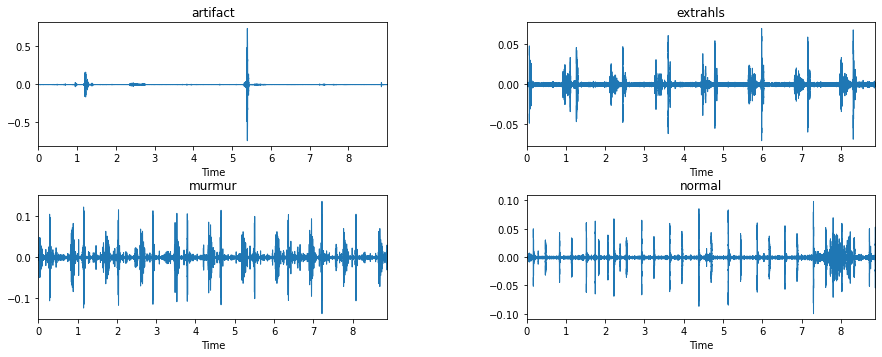

In [53]:
# To plot the waveforms, using librosa's display.waveplot function:

fig = plt.figure(figsize=(15,15))
#experiment.log_image('label_examples.png')
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
for i, lab in enumerate(labels):
    fn = files[lab]
    print(fn)
    fig.add_subplot(5,2,1+i)
    plt.title(lab)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr = sample_rate)
plt.savefig('label_examples.png')

# Log graphic of waveforms to comet:
experiment.log_image('label_examples.png')

In [ ]:
# COMET WARNING: As you are running in a Jupyter environment, 
# you will need to call `experiment.end()` when finished to 
# ensure all metrics and code are logged before exiting.

### LEMBRAR DE RETIRAR DE COMENT PRA FINALIZAR
# experiment.end() 